In [1]:
import pandas as pd

blood_alpha_synuclein = pd.read_csv('/Users/larsheijnen/Thesis/data/blood/BLOOD_DATE_FORMATTED_CSF_FILTERED_ALPHA.csv')

In [3]:
# Find PATNOs with exactly 5 occurrences
patnos_with_5_visits = blood_alpha_synuclein['PATNO'].value_counts()
patnos_with_5_visits = patnos_with_5_visits[patnos_with_5_visits == 5].index.tolist()

print("PATNOs with 5 visits:", patnos_with_5_visits)

PATNOs with 5 visits: [3431, 3434, 3433, 3424, 3430, 3429, 3428, 4090, 4091, 3436, 3423, 3421, 3435, 3763, 3439, 3458, 3471, 3470, 3469, 3468, 3467, 3466, 3464, 3462, 3461, 3459, 3457, 3442, 3455, 3454, 3453, 3452, 3451, 3448, 3446, 3420, 3444, 3443, 3445, 3410, 3419, 3369, 3367, 3365, 3364, 4101, 3362, 3361, 3360, 3359, 3358, 3357, 3355, 3354, 3352, 3351, 3350, 4102, 4103, 4104, 4106, 3368, 3371, 3418, 3372, 3415, 3411, 3476, 3409, 3407, 3404, 3403, 4093, 3400, 4094, 3385, 3383, 4098, 3378, 3377, 4099, 3375, 3374, 3373, 3473, 3527, 3500, 3752, 3770, 3769, 3767, 3001, 3760, 3759, 3756, 3951, 3952, 3955, 3505, 3957, 3959, 3960, 3961, 3658, 4001, 4010, 3654, 3653, 3773, 3776, 3777, 3780, 3854, 3826, 3825, 3824, 3823, 3856, 3819, 3817, 3814, 3812, 3811, 3900, 3807, 3903, 3803, 3800, 3905, 3789, 3907, 3650, 4018, 4020, 4054, 3563, 3559, 3557, 3556, 3554, 4056, 4057, 4058, 4059, 4067, 4070, 3532, 3528, 3323, 4072, 3523, 4076, 3515, 4077, 3565, 3567, 4022, 3570, 4024, 4027, 3625, 3624, 3619,

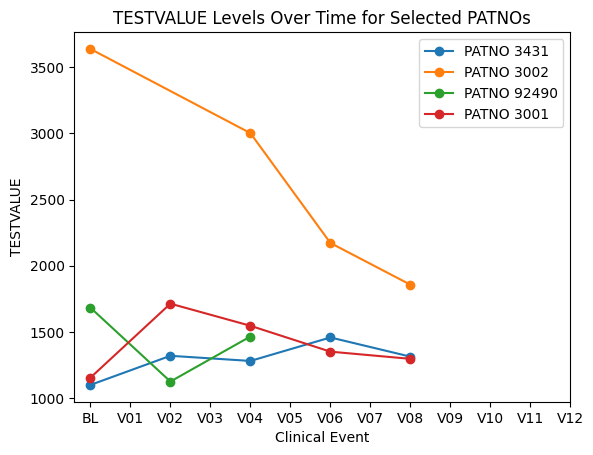

In [11]:
import matplotlib.pyplot as plt

# Define the function to plot the data
def plot_patnos(df, patnos):
    # Define the event order and mapping
    event_order = ['BL'] + [f'V{i:02d}' for i in range(1, 13)]  # Adjust range as needed
    event_map = {event: idx for idx, event in enumerate(event_order)}

    # Filter the data for the specified PATNOs
    filtered_data = df[df['PATNO'].isin(patnos)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the temporal change for each PATNO
    for patno in patnos:
        patient_data = filtered_data[filtered_data['PATNO'] == patno].copy()
        patient_data['TESTVALUE'] = pd.to_numeric(patient_data['TESTVALUE'], errors='coerce')
        patient_data['order'] = patient_data['CLINICAL_EVENT'].astype(str).map(event_map)
        patient_data = patient_data.dropna(subset=['order']).sort_values(by='order')
        ax.plot(patient_data['order'], patient_data['TESTVALUE'], marker='o', label=f"PATNO {patno}")

    # Set axis labels and ticks
    ax.set_xticks(list(event_map.values()))
    ax.set_xticklabels(list(event_map.keys()))
    ax.set_xlabel("Clinical Event")
    ax.set_ylabel("TESTVALUE")
    ax.set_title("TESTVALUE Levels Over Time for Selected PATNOs")
    ax.legend()

    plt.show()

# Example usage
selected_patnos = [3431, 3002, 92490, 3001]  # Replace with your desired PATNOs
plot_patnos(blood_alpha_synuclein, selected_patnos)


--- Linear Mixed-Effects Model Results ---
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   TESTVALUE  
No. Observations:    2921      Method:               REML       
No. Groups:          919       Scale:                116207.7295
Min. group size:     1         Log-Likelihood:       -22212.1779
Max. group size:     10        Converged:            Yes        
Mean group size:     3.2                                        
----------------------------------------------------------------
                Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------
Intercept       1578.223   22.171 71.183 0.000 1534.768 1621.678
visit_numeric     -4.587    2.929 -1.566 0.117  -10.327    1.153
Group Var     363807.690   67.847                               


--- Interpretation of Visit Trend ---
Estimated change in TESTVALUE per visit step: -4.5873
P-value for visit trend: 0.1173

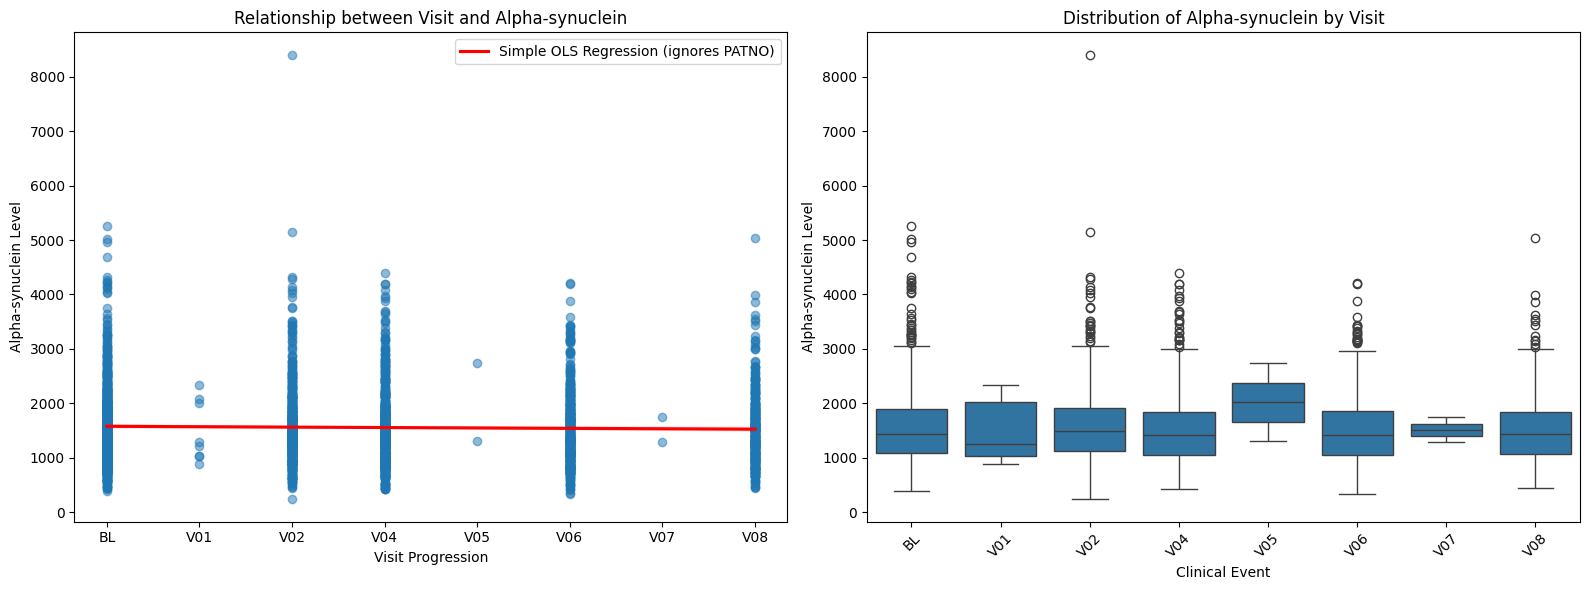

In [ ]:
import numpy as np
import pandas as pd # Make sure pandas is imported if not already
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf # Import statsmodels

# Define the visit order - CHECK if V03 is missing intentionally or exists in data
# If V03 exists and should be included, add it here and to the event_map
event_order = ['BL', 'V01', 'V02', 'V04', 'V05', 'V06', 'V07', 'V08']
event_map = {event: idx for idx, event in enumerate(event_order)}

# Create a copy to avoid modifying the original dataframe
alpha_syn_analysis = blood_alpha_synuclein.copy()

# Convert CLINICAL_EVENT to numeric and TESTVALUE to numeric
alpha_syn_analysis['visit_numeric'] = alpha_syn_analysis['CLINICAL_EVENT'].map(event_map)
alpha_syn_analysis['TESTVALUE'] = pd.to_numeric(alpha_syn_analysis['TESTVALUE'], errors='coerce')

# Drop rows with missing values needed for the analysis
# Note: LMMs can sometimes handle missing data better than dropping, but for simplicity here, we'll drop.
clean_data = alpha_syn_analysis.dropna(subset=['visit_numeric', 'TESTVALUE', 'PATNO'])

# Check if there's enough data to proceed
if clean_data.empty or clean_data['visit_numeric'].nunique() < 2:
    print("Not enough valid data points or visits to perform the analysis.")
else:
    # --- Linear Mixed-Effects Model ---
    # We model TESTVALUE as a function of the visit progression (visit_numeric).
    # We include a random intercept for each PATNO to account for baseline differences
    # and the repeated measures structure.
    print("\n--- Linear Mixed-Effects Model Results ---")
    try:
        # Define and fit the model
        # Formula: TESTVALUE depends on visit_numeric (fixed effect)
        # Groups: Observations are grouped by PATNO
        # re_formula="~1": We fit a random intercept for each group (PATNO)
        lmm_formula = "TESTVALUE ~ visit_numeric"
        model = smf.mixedlm(lmm_formula, clean_data, groups=clean_data['PATNO'])
        result = model.fit()

        # Print the model summary
        print(result.summary())

        # --- Interpretation ---
        # Look at the 'Coef.' and 'P>|z|' for the 'visit_numeric' row.
        # Coef.: The estimated average change in TESTVALUE for each step increase in visit_numeric.
        # P>|z|: The p-value for the test that the coefficient is zero.
        visit_coef = result.params['visit_numeric']
        visit_pvalue = result.pvalues['visit_numeric']

        print("\n--- Interpretation of Visit Trend ---")
        print(f"Estimated change in TESTVALUE per visit step: {visit_coef:.4f}")
        print(f"P-value for visit trend: {visit_pvalue:.4f}")

        if visit_pvalue < 0.05:
            if visit_coef < 0:
                print("There is a statistically significant decrease in TESTVALUE over visits.")
            elif visit_coef > 0:
                print("There is a statistically significant increase in TESTVALUE over visits.")
            else:
                print("There is a statistically significant effect of visit, but the coefficient is near zero.")
        else:
            print("There is no statistically significant linear trend in TESTVALUE over visits.")

    except Exception as e:
        print(f"\nCould not fit the Linear Mixed-Effects Model. Error: {e}")
        print("This might happen if data structure is unsuitable (e.g., too few subjects per visit).")


    # --- Visualizations (still useful) ---
    print("\n--- Generating Visualizations ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Scatter plot with regression line (Note: line ignores repeated measures)
    sns.regplot(x='visit_numeric', y='TESTVALUE', data=clean_data, ax=ax1,
                line_kws={'color':'red', 'label':'Simple OLS Regression (ignores PATNO)'},
                scatter_kws={'alpha':0.5})
    ax1.set_xlabel('Visit Progression')
    ax1.set_ylabel('Alpha-synuclein Level')
    ax1.set_title('Relationship between Visit and Alpha-synuclein')
    ax1.set_xticks(range(len(event_order)))
    ax1.set_xticklabels(event_order)
    # Add LMM slope for comparison if desired (more advanced plotting)
    # x_vals = np.array(ax1.get_xlim())
    # y_vals = result.params['Intercept'] + result.params['visit_numeric'] * x_vals
    # ax1.plot(x_vals, y_vals, color='blue', linestyle='--', label='LMM Fixed Effect Trend')
    ax1.legend()


    # 2. Box plot to show distribution by visit
    sns.boxplot(x='CLINICAL_EVENT', y='TESTVALUE', data=clean_data, order=event_order, ax=ax2)
    ax2.set_xlabel('Clinical Event')
    ax2.set_ylabel('Alpha-synuclein Level')
    ax2.set_title('Distribution of Alpha-synuclein by Visit')
    plt.sca(ax2) # Set current axis for plt functions
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# --- END REPLACEMENT CELL ---